In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
import theano.tensor as tt

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} M f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

Useful re-writing:
$$
A = \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda
$$

$$
B^{-1} = C^{-1} - C^{-1} M \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda M^T C^{-1}
$$

In [3]:
class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def A_chol(self):
        return self._A_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is completely flat, so we set the first row and column of the precision matrix to zero
        Lambda_inv = tt.nlinalg.matrix_inverse(Lambda[1:,1:]) # Bad, wrong, don't do it, but it works
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        L_sub_chol = tt.slinalg.cholesky(Lambda[1:,1:])

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        a = tt.slinalg.solve(AInv, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))
        A = tt.nlinalg.matrix_inverse(AInv) # Bad, wrong, don't do it, but it works
        chol_A = tt.slinalg.cholesky(A)

        self._a = a
        self._A_chol = chol_A

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) - 2*tt.sum(tt.log(tt.diag(chol_A))) + 2*tt.sum(tt.log(tt.diag(L_sub_chol)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = np.random.default_rng()

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + (tt.dot(self.A_chol, rng.normal(size=(nylm, size)))).T

In [4]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

nt = 100000

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=30.0, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.2, m=0.1, prot=1.0,
                porb=4.887802443, ecc=0.0, Omega=30.0)
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

y_true = sp.sample_ylm().eval()[0,:]
y_true[0] = 1.0

t = np.linspace(-100*sec.porb.eval(), 100*sec.porb.eval(), nt)
flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true

sigma_flux = 0.005*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


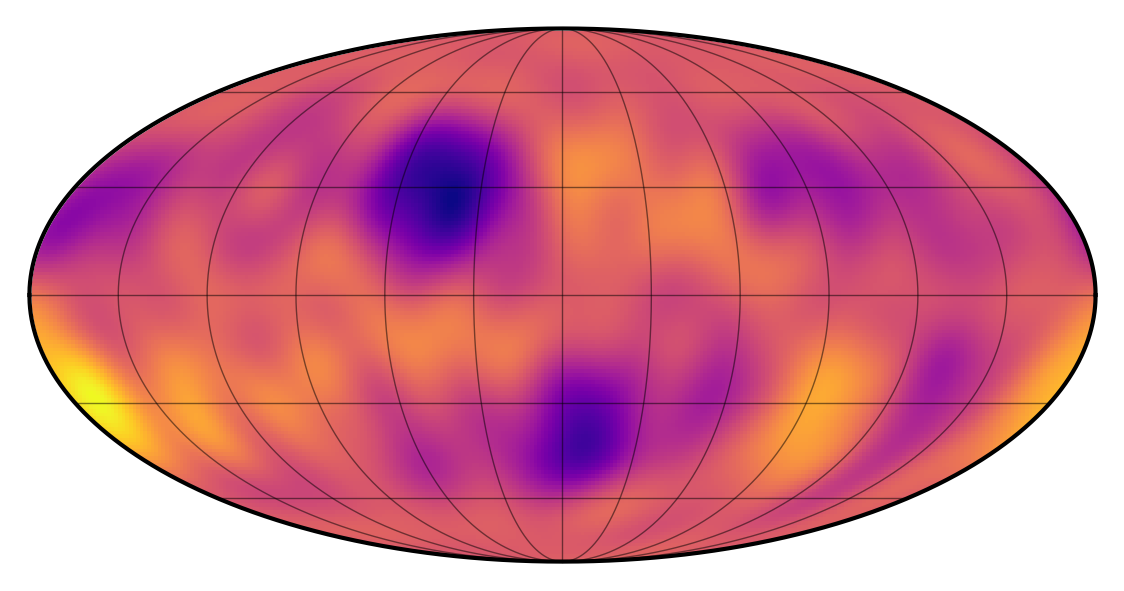

In [5]:
sp.visualize(y_true)

<ErrorbarContainer object of 3 artists>

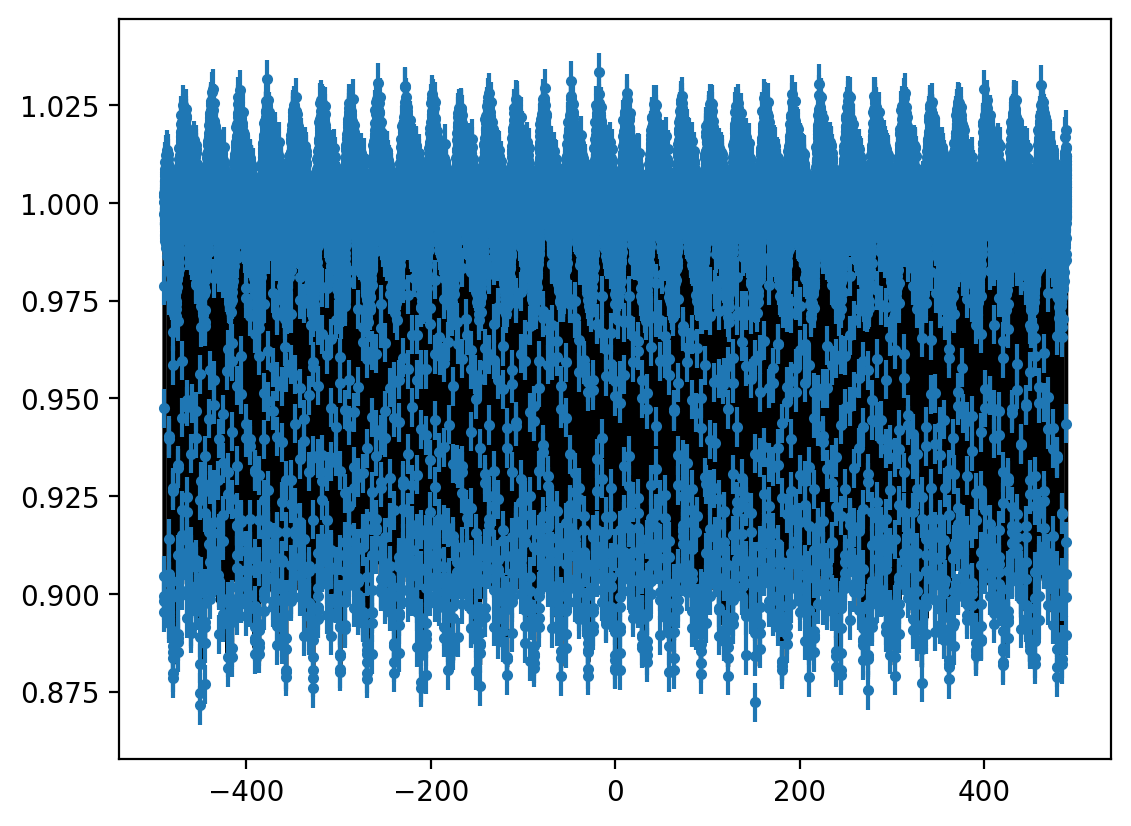

In [6]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

(-0.4887802443, 0.4887802443)

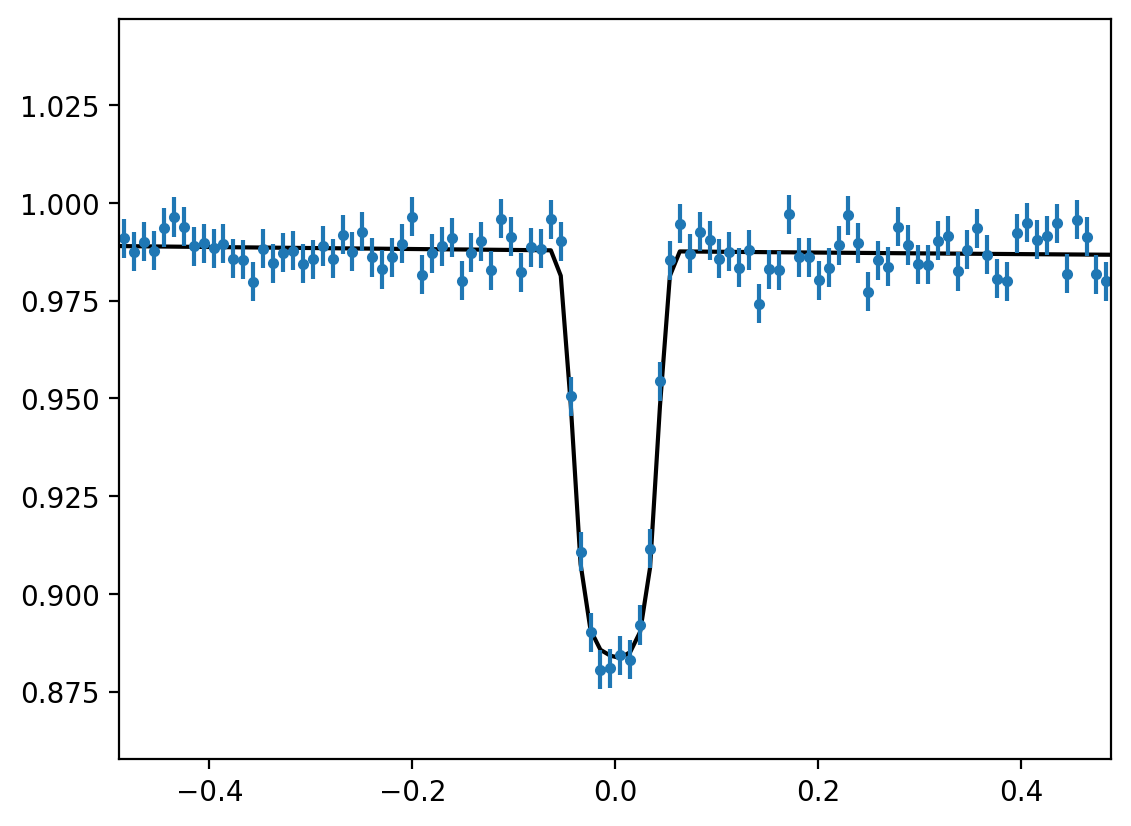

In [7]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)

In [8]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

(-0.4887802443, 0.4887802443)

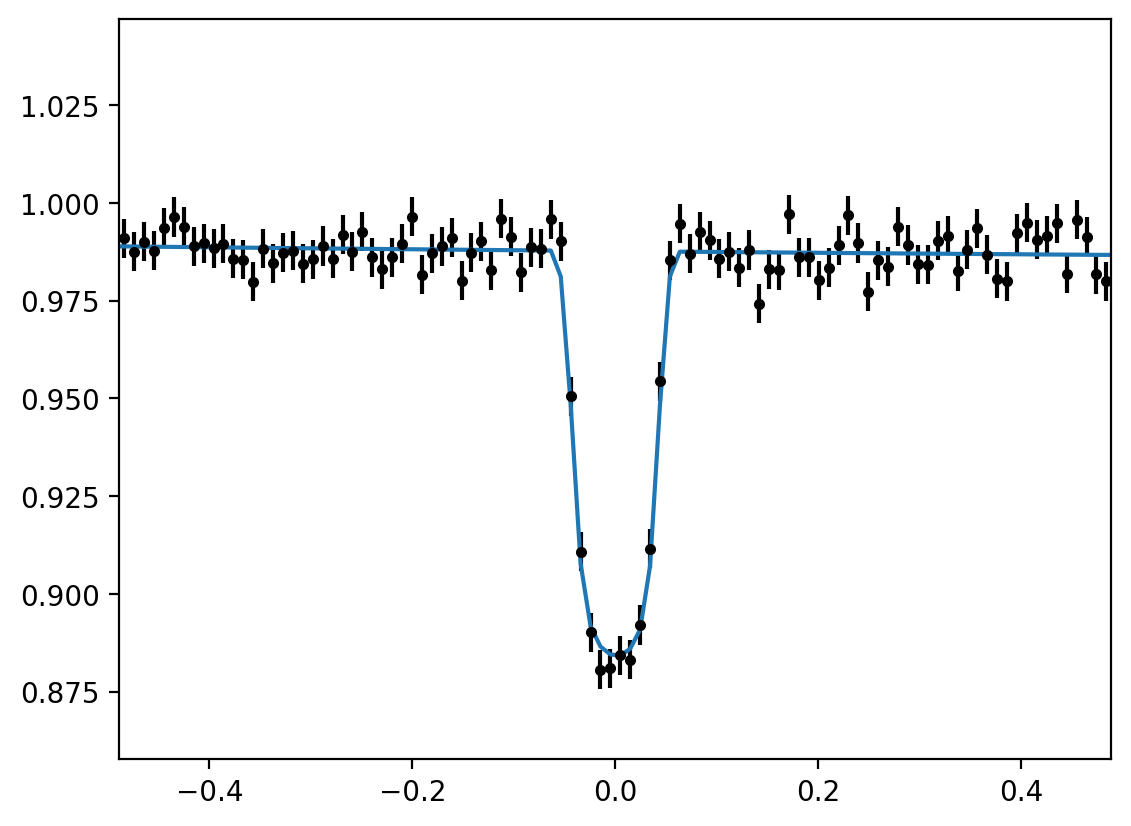

In [9]:
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.', color='k')
plt.plot(t, ssp.design_matrix.eval() @ ssp.a.eval())
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


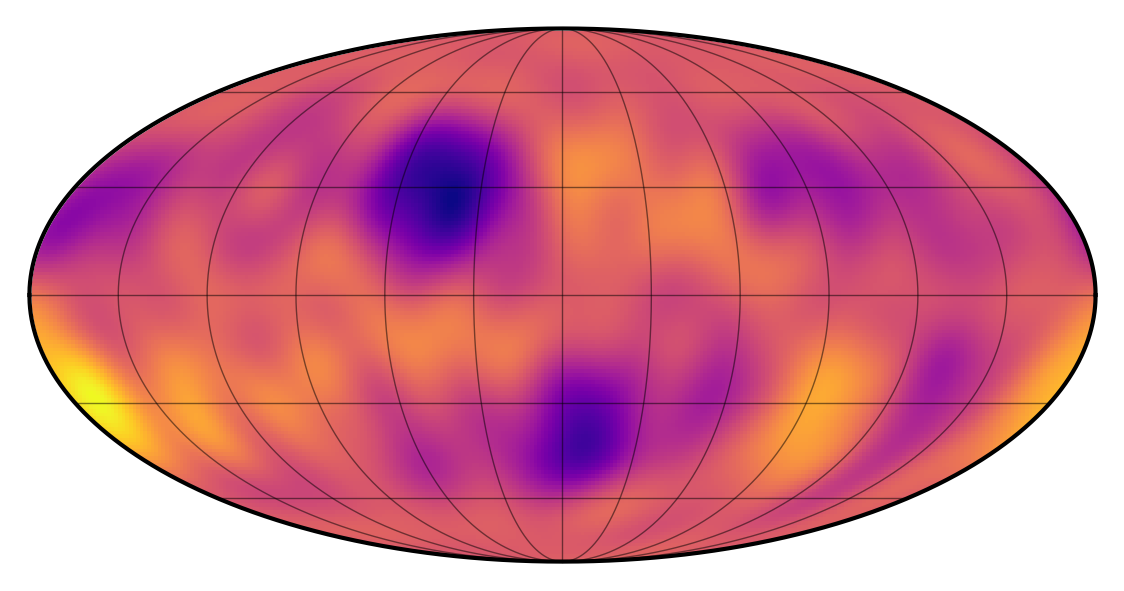

In [10]:
sp.visualize(y_true)

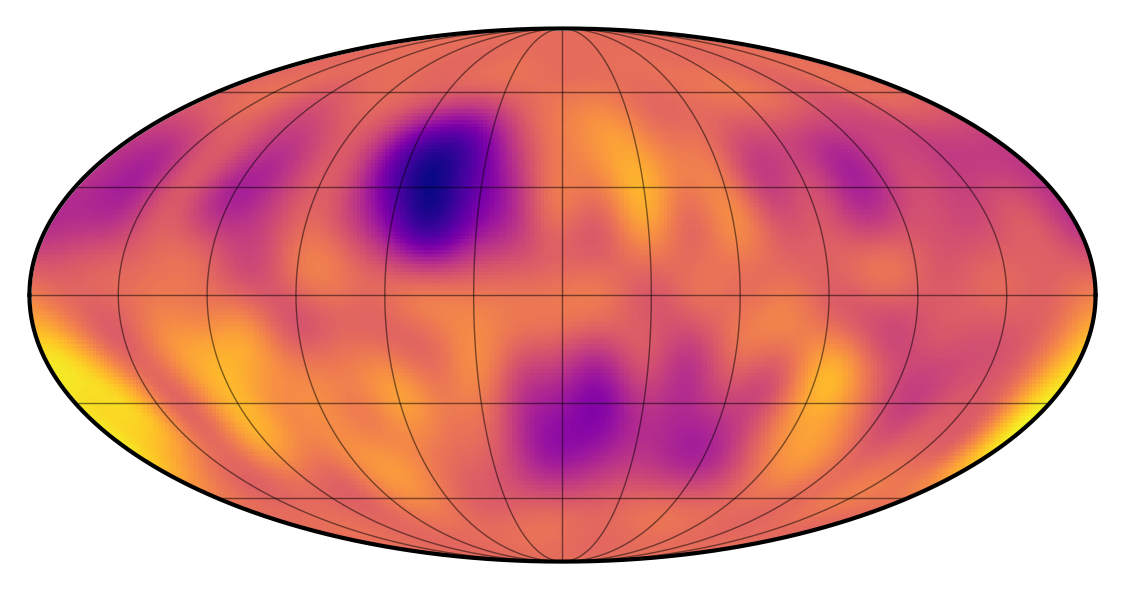

In [11]:
sp.visualize(ylm_draw)

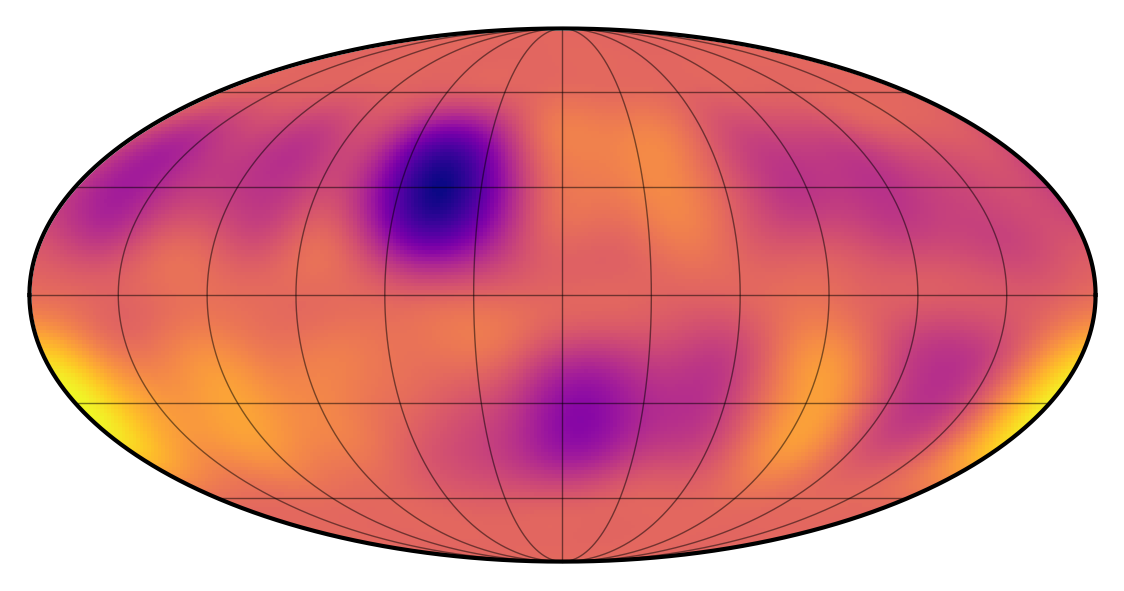

In [12]:
sp.visualize(ssp.a.eval())

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [13]:
r = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(r)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

389501.1554191973

In [14]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(ylm_draw - ssp.a.eval(), sl.cho_solve((ssp.A_chol.eval(), True), ylm_draw - ssp.a.eval())) - np.sum(np.log(np.diag(ssp.A_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

389501.1554175844